#  Домашнее задание по NLP # 2 [100 баллов] 
## Составление словарей для классификации по тональности
При классификации текстов или предложений по тональности необходимо использовать оценочные словари для предметной области, то есть, такие словари, в которых содержатся отрицательные и позитивные слова для какой-то предметной области. Идея подобных словарей основана на следующих наблюдениях: во-первых, для разных товаров используются разные оценочные слова (например бывает “захватывающая книга”, но не бывает “захватывающих лыж”), во-вторых, в контексте разных товаров одни и те же слова могут иметь разную окраску (слово “тормоз” в отзыве на велосипед имеет нейтральную окраску, в отзыве на компьютер – резко негативную, “пыль” в контексте пылесосов – нейтральную, в контексте кофемолок – положительную (“мелкий помол в пыль”)). Еще один пример: "теплое пиво" – это плохо, а "теплый свитер" – это хорошо.  

Составление таких словарей в ручную – трудоемкий процесс, но, к счастью, его не сложно автоматизировать, если собрать достаточно большие корпуса отзывов. В этом домашнем задании вам предстоит попробовать реализовать один их подходов к составлению оценочных словарей, основанный на статье Inducing Domain-Specific Sentiment Lexicons from Unlabeled Corpora (https://nlp.stanford.edu/pubs/hamilton2016inducing.pdf).


Данные для задания – уже знакомые вам отзывы на банки, собранные с нескольких сайтов Рунета. Отзывы могут быть как положительными (оценка 5), так и отрицательными (оценка 1).

## Часть 1. Обучение модели word2vec [50 баллов]

1. Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова. 
2. Обучите по коллекции предложений word2vec
3. Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:
    * тест на определение ближайших слов
    * тест на аналогии (мужчина – король : женщина – королева)
    * тест на определение лишнего слова.
    
4. Постройте несколько визуализаций:
    * TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов
    * задайте координаты для нового пространства следующим образом: одна  ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах.  Более формально:
    берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.  
 


Ссылка на примеры визуализаций: https://towardsdatascience.com/game-of-thrones-word-embeddings-does-r-l-j-part-2-30290b1c0b4b

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import re
from pymystem3 import Mystem
from pymorphy2 import MorphAnalyzer
from nltk.stem.snowball import RussianStemmer
from nltk import FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud
from pprint import pprint

import multiprocessing

from nltk.tokenize import sent_tokenize
from nltk import FreqDist
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

from sklearn.manifold import TSNE



### подготовка данных

In [2]:
%%time
df_chunk = pd.read_json('./banki_responses.json.bz2', compression='bz2', lines=True, orient='records', chunksize=1000)
df = pd.concat(df_chunk, ignore_index=True)

CPU times: user 1min 18s, sys: 446 ms, total: 1min 19s
Wall time: 1min 19s


In [3]:
#df1 = df['text'].sample(100)
#df1

In [4]:
texts = df['text'].str.cat(sep=' ')
#texts = df1.str.cat(sep=' ')
#texts

In [5]:
m = Mystem()
regex = re.compile("[А-Яа-я.!?]+")
regex1 = re.compile("[А-Яа-я]+")
mystopwords = ['г.', 'т.к.', 'руб.', 'т.е.', 'ул.', 'д.', 'т.д.', 'п.']
def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""
    
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""    

def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "


Выбираем из текста слова и знаки окончания предолжений

In [6]:
%%time
texts = words_only(texts)
#texts

CPU times: user 16.6 s, sys: 2.48 s, total: 19.1 s
Wall time: 20.6 s


Перед разбиением на предложения удаляем стоп слова типа 'г.', 'т.к.', 'руб.', 'т.е.', 'ул.', 'д.', 'т.д.', 'п.'

In [7]:
%%time
texts = remove_stopwords(texts)
#texts

CPU times: user 13.9 s, sys: 1.65 s, total: 15.6 s
Wall time: 15.6 s


Разбиваем текст на предложения

In [8]:
%%time
texts = sent_tokenize(texts)
#texts[:5]

CPU times: user 3min 16s, sys: 1.01 s, total: 3min 17s
Wall time: 3min 17s


Делаем лемматизацию предложений

In [9]:
%%time
texts = [lemmatize(text.lower()) for text in texts]
#texts[:5]

CPU times: user 11min 27s, sys: 1min 21s, total: 12min 48s
Wall time: 46min 5s


Избавляемся от знаков окончания предложения и пустых строк

In [10]:
%%time
texts = [words_only(text, regex=regex1) for text in texts]
texts = [text for text in texts if text != '']
#texts

CPU times: user 19.1 s, sys: 42.2 ms, total: 19.2 s
Wall time: 19.2 s


In [11]:
#texts

Формируем массив массивов слов для обучения word2vec

In [12]:
texts = [text.split() for text in texts]

In [13]:
#texts

### Обучение word2vec

Объединяем в биграммы слова, которые часто встречаются вместе

In [14]:
%%time
phrases = Phrases(texts)
bigram = Phraser(phrases)

CPU times: user 2min 43s, sys: 340 ms, total: 2min 43s
Wall time: 2min 44s


In [15]:
texts = bigram[texts]

Обучаем модель word2vec с размерностью эмбединга 100, контекстом $\pm5$, минимальная частота слова для включения в словарь = 5, negative sampling = 5 (для оптимизации времени обучения модели) 

In [16]:
%%time
model = Word2Vec(texts, size=100, window=5, min_count=5, workers=4, negative=5)
model.save('./my_w2v_1.model')

CPU times: user 30min 34s, sys: 2.23 s, total: 30min 36s
Wall time: 25min 41s


In [17]:
len(model.wv.vocab)

53718

In [18]:
model = Word2Vec.load('./my_w2v_1.model') 

In [19]:
wv = model.wv

In [ ]:
del model, df

### Тесты

тест на определение ближайших словa

In [21]:
wv.most_similar('кредит')

[('автокредит', 0.881902277469635),
 ('потребительский_кредит', 0.8681466579437256),
 ('потребкредит', 0.8344552516937256),
 ('ипотека', 0.8240091800689697),
 ('ссуда', 0.7696859240531921),
 ('товарный_кредит', 0.7684568762779236),
 ('рассрочка', 0.7061496376991272),
 ('автокред', 0.6541863083839417),
 ('потреба', 0.6463698744773865),
 ('пай', 0.6314750909805298)]

In [22]:
wv.most_similar('очередь')

[('живой_очередь', 0.8167122006416321),
 ('длинный_очередь', 0.7925763130187988),
 ('километровый_очередь', 0.7845910787582397),
 ('часовой_очередь', 0.7611654996871948),
 ('громадный_очередь', 0.7395672798156738),
 ('толпа', 0.727716326713562),
 ('многочасовой_очередь', 0.7092833518981934),
 ('электронный_очередь', 0.7059051990509033),
 ('длиннющий_очередь', 0.6956241130828857),
 ('толпа_народ', 0.6808080673217773)]

In [23]:
wv.most_similar('интернет_банкинг')

[('онлайн_банкинг', 0.9145123958587646),
 ('мкб_онлайн', 0.8677463531494141),
 ('иб', 0.8627710342407227),
 ('альфа_клик', 0.8624495267868042),
 ('телебанк', 0.8589620590209961),
 ('веб_банкинг', 0.857448160648346),
 ('траст_онлайн', 0.8483586311340332),
 ('мобильный_приложение', 0.8479665517807007),
 ('отп_директ', 0.8176249265670776),
 ('система_телебанк', 0.8121195435523987)]

тест на аналогии (мужчина – король : женщина – королева)

In [24]:
wv.most_similar(positive=["хорошо","плохой"], negative=["хороший"])

[('плохо', 0.708453357219696),
 ('нормально', 0.614814043045044),
 ('надо', 0.5606327056884766),
 ('печально', 0.552887499332428),
 ('сложно', 0.5461524128913879),
 ('странно', 0.5362855195999146),
 ('здорово', 0.5333023071289062),
 ('чудесно', 0.531540036201477),
 ('гуд', 0.5305284261703491),
 ('ока', 0.5245696306228638)]

In [25]:
wv.most_similar(positive=["женщина","сотрудник"], negative=["мужчина"])

[('работник', 0.885513186454773),
 ('сотрудница', 0.8317578434944153),
 ('специалист', 0.7722759246826172),
 ('менеджер', 0.7218571901321411),
 ('служащий', 0.7124825119972229),
 ('работница', 0.6796690225601196),
 ('персонал', 0.6774367690086365),
 ('руководитель', 0.6615720987319946),
 ('клерк', 0.658801794052124),
 ('кредитный_инспектор', 0.6476816534996033)]

тест на определение лишнего слова.

In [26]:
wv.doesnt_match("ипотека автокредит ссуда депозит".split())

'депозит'

In [27]:
# здесь без комментариев :)
wv.doesnt_match("сбербанк альфабанк газпромбанк тинькоффбанк юникредитбанк".split())

'тинькоффбанк'

### TSNE для топ-500 слов из словаря

In [28]:
top_words = []
fd = FreqDist()
for text in texts:
    fd.update(text)
for i in fd.most_common(500):
    top_words.append(i[0])
print(top_words)

['в', 'я', 'и', 'не', 'на', 'что', 'банк', 'быть', 'с', 'по', 'карта', 'то', 'это', 'а', 'мой', 'как', 'но', 'этот', 'за', 'у', 'деньги', 'кредит', 'о', 'который', 'так', 'вы', 'клиент', 'отделение', 'они', 'сотрудник', 'день', 'весь', 'к', 'мочь', 'счет', 'она', 'же', 'свой', 'для', 'сказать', 'сумма', 'от', 'уже', 'из', 'год', 'через', 'получать', 'такой', 'все', 'он', 'заявление', 'мы', 'раз', 'при', 'вопрос', 'только', 'нет', 'время', 'другой', 'еще', 'до', 'один', 'если', 'приходить', 'какой', 'вклад', 'ваш', 'после', 'когда', 'данный', 'тот', 'телефон', 'ответ', 'звонить', 'номер', 'офис', 'очень', 'месяц', 'кредитный', 'банкомат', 'договор', 'позвонить', 'обращаться', 'проблема', 'написать', 'решать', 'платеж', 'или', 'работать', 'бы', 'чтобы', 'работа', 'ни', 'рубль', 'отвечать', 'без', 'звонок', 'со', 'документ', 'сбербанк', 'говорить', 'где', 'почему', 'вот', 'давать', 'оформлять', 'там', 'ситуация', 'хотеть', 'сделать', 'человек', 'просто', 'информация', 'сообщать', 'должный

In [29]:
top_words_vec = wv[top_words]
top_words_vec.shape

(500, 100)

In [30]:
tsne = TSNE(n_components=2, random_state=0)
top_words_tsne = tsne.fit_transform(top_words_vec)

In [31]:
top_words_tsne.shape

(500, 2)

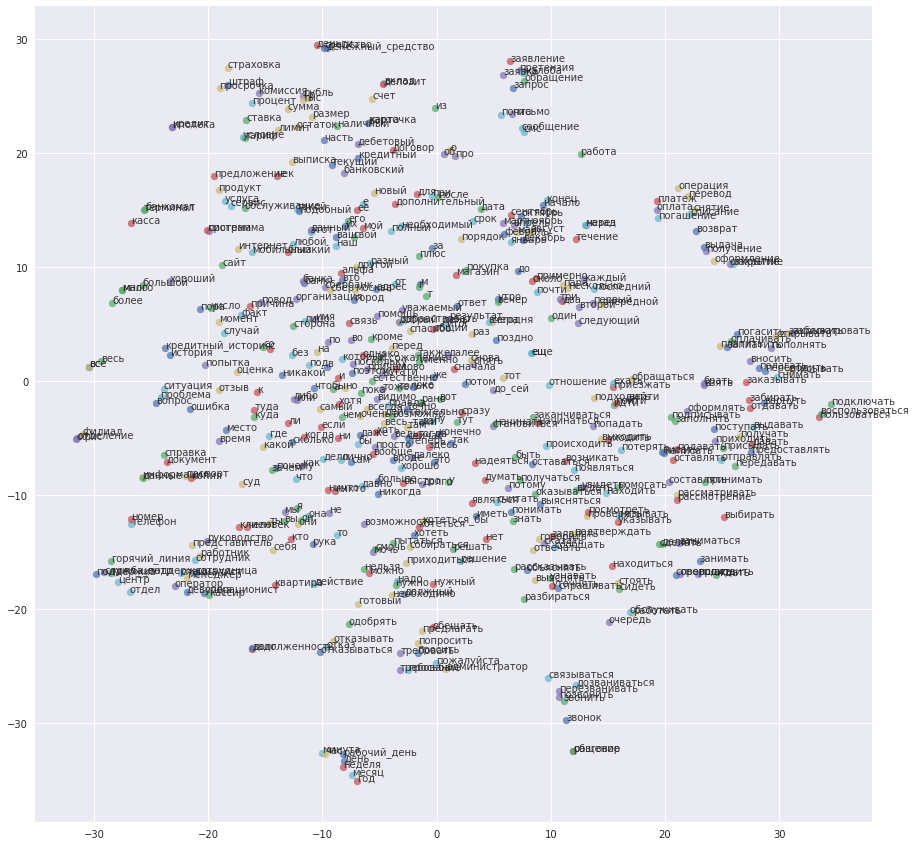

In [328]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1,1,1)
for i in range(len(top_words)):
    ax.scatter(
        x=top_words_tsne[i, 0], 
        y=top_words_tsne[i, 1],
        alpha=0.7,
    )
    ax.text(
        x=top_words_tsne[i, 0], 
        y=top_words_tsne[i, 1],
        s=top_words[i],
        alpha=0.9,
    )
plt.show()

Различимы следующие кластеры:
- способы связи - связываться, звонить 
- минута, день, неделя, год, рабочий день
- сотрудники банка - кассир, операционист, работник
- очень большой кластер глаголов (справа)


### word2viz визуализация. 

In [33]:
#x_new = 'плохо - хорошо'
#y_new = 'медленно - быстро'
#words = ['сбербанк', 'альфабанк']
def word2viz_plot(words, x_new, y_new):
    x2, x1 = x_new.split(" - ")
    y2, y1 = y_new.split(" - ")
    x_label = "%s --------> %s" % (x2, x1)
    y_label = "%s --------> %s" % (y2, y1)
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(1,1,1)
    for word in words:
        x = wv[word].dot(wv[x2] - wv[x1])
        y = wv[word].dot(wv[y2] - wv[y1])
        ax.scatter(x, y, alpha=0.7)
        ax.text(x, y, word, alpha=0.7)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.show()    


Проекции векторов на векторы "плохо - хорошо",и "медленно - быстро" 

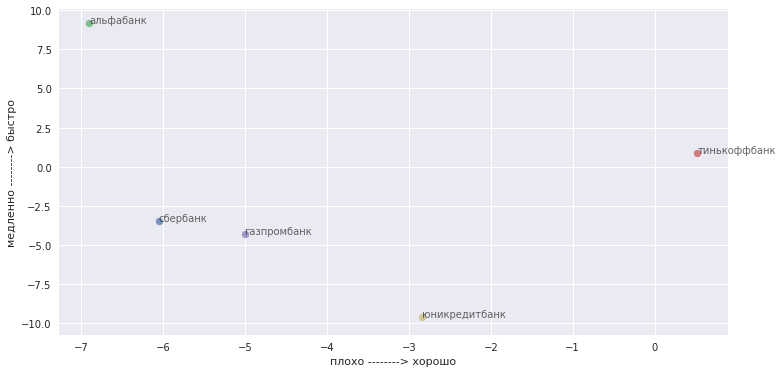

In [34]:
word2viz_plot(['сбербанк', 'альфабанк', 'тинькоффбанк', 'газпромбанк','юникредитбанк'], 'плохо - хорошо', 'медленно - быстро')

Проекции векторов на векторы "легко - сложно",и "медленно - быстро" 

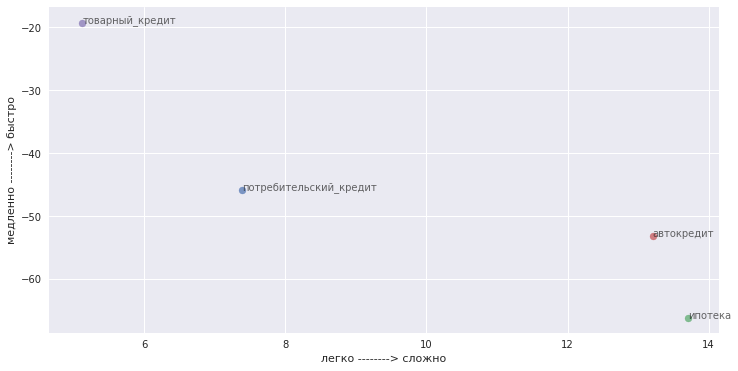

In [35]:
word2viz_plot(['потребительский_кредит', 'ипотека', 'автокредит', 'товарный_кредит'], 'легко - сложно', 'медленно - быстро')

## Часть 2. Распространение метки [50 баллов]

Определите 5-8 позитивных слов (например, “быстрый”, “удобный”) и 5-8  негативных слов (например,“очередь”, “медленно”). Эти слова будут основной будущего оценочного словаря. Пусть позитивному классу соответствует метка 1, негативному – -1. Пометьте выбранные слова в лексическом графе соответствующими метками. Запустите любой известный вам метод распространения метки (Label Propogation) в лексическом графе. На выходе метода распространения ошибки должны быть новые слова, помеченные метками 1 и -1 – это и есть искомые оценочные слова.

Алгоритмы распространения метки устроены примерно так: пусть мы находимся в выршине, помеченном +1. С какой-то вероятностью мы переносим эту метку на соседние узлы. С меньшей вероятностью переносим ее на вершины на расстоянии два. В конце распространения метки, часть вершин оказывается помечена меткой +1, часть – -1, большая часть остается без метки.

Рекомендуемые алгоритмы распространения метки:
1. ```graphlab.label_propagation``` (```graphlab``` доступен бесплатно по образовательной лицензии)
2. ```sklearn.semi_supervised.LabelPropagation``` 
3. ```sklearn.semi_supervised.LabelSpreading```

In [329]:
#words_pos = ['быстрый', 'удобный', 'легко', 'радость', 'удача', 'хорошо']
#words_neg = ['очередь', 'медленно', 'раздражение', 'ярость', 'дорого', 'сложно']
words_pos = ['быстрый', 'удобный', 'хорошо']
words_neg = ['очередь', 'медленно', 'сложно']

In [330]:
#vocab = list(wv.vocab)
vocab = list(set(top_words) | set(words_pos) | set(words_neg))
#На всем словаре wv.vocab не смог обучить LabelPropagation. 'knn' из-за ошибки деления на ноль, 'rbf' из-за нехватки памяти
#Для обучения берем top500 неразмеченных и 12 размеченных слов.
#После обучения вновь построим график TSNE с цветами по классам

In [331]:
#непомеченные данные для LabelPropagation должны иметь метку -1
labels = pd.Series(-1, index=vocab, dtype=int)

In [332]:
labels.head()

разговор     -1
заниматься   -1
выясняться   -1
видимо       -1
ошибка       -1
dtype: int64

In [333]:
#vocab

In [334]:
labels[words_pos] = 1
labels[words_neg] = 0

In [335]:
labels.value_counts()

-1    498
 1      3
 0      3
dtype: int64

In [336]:
from sklearn.semi_supervised import LabelSpreading


In [337]:
%%time
label_prop_model = LabelSpreading(kernel='knn', n_jobs=-1, max_iter=1000)
label_prop_model.fit(wv[vocab], labels.values)

CPU times: user 89.1 ms, sys: 4.04 ms, total: 93.1 ms
Wall time: 126 ms


/home/max/anaconda3/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


In [338]:
labels = pd.Series(label_prop_model.predict(wv[vocab]), index=labels.index)
#labels = pd.Series(label_prop_model.transduction_, index=labels.index)

In [339]:
labels.value_counts()

0    403
1    101
dtype: int64

###  TSNE для топ-500 слов из словаря

Визуализируем метки неразмеченных данных, предсказанных моделью

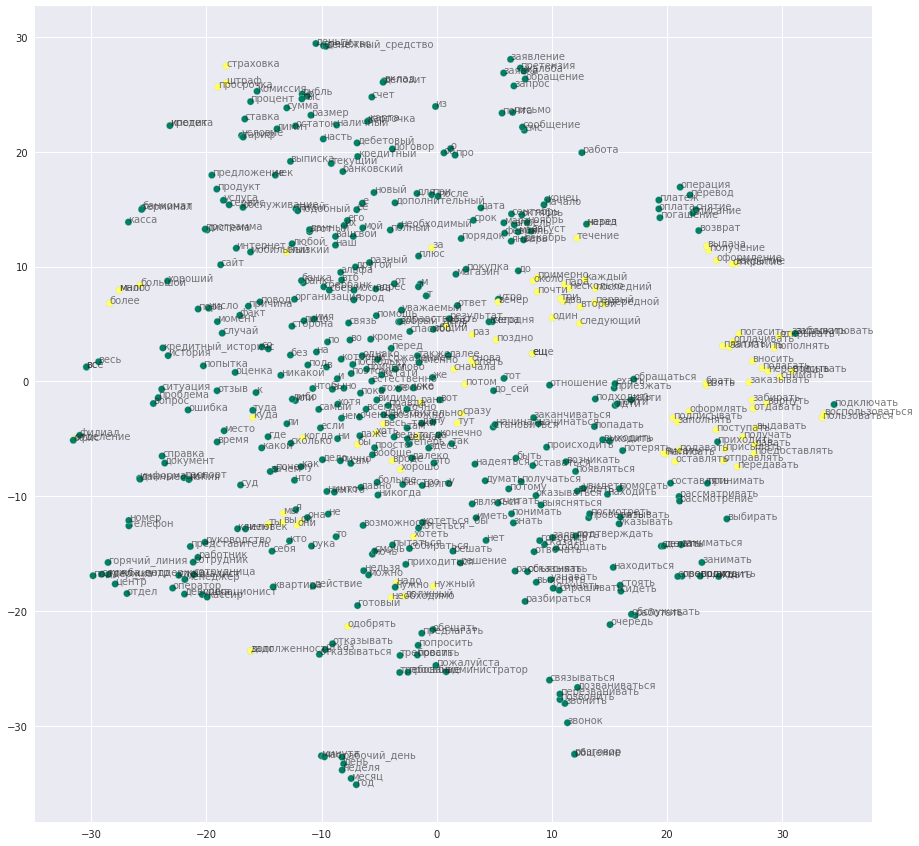

In [350]:
fig = plt.figure(figsize=(15,15))
plt.scatter(top_words_tsne[:, 0], top_words_tsne[:, 1], c=labels[top_words], cmap='summer', alpha=1, s=50, marker='o', edgecolors='lightgrey')
for i in range(len(top_words)):
    plt.text(top_words_tsne[i, 0], top_words_tsne[i, 1], s=top_words[i], alpha=0.6)
